In [1]:
import nltk
import numpy as np
import pickle
import pandas as pd
import json

In [ ]:
## must download vader_lexicon for vader sentiment algorithm
nltk.download_shell()

# Data Loading

### Load clean, processed data

In [17]:
df = pd.read_pickle("df3")

In [18]:
df.shape

(111009, 10)

In [19]:
## array of strings, 1 x n 
descriptions = df["description"].tolist()

## array of ints, 1 x n
prices = df["price"].tolist()

## array of ints, 1 x n
points = df["points"].tolist()

# Sentiment Analysis Feature Transformation

### Sentiment analysis algorithms. Each takes a single string as input.

In [15]:
def createDict():
    sentiment_dictionary = {}
    for line in open('afinn_dict.txt'):
        word,score = line.split('\t')
        sentiment_dictionary[word] = int(score)
    return sentiment_dictionary
sentiment_dictionary = createDict()

def sentimentAfinn(sentence):
    '''
    AFINN is a dictionary of polarity scores [-5,5] by word.
    This algorithm sums the scores for each word in the sentence, then
    classifies the entire sentence based on the sum's sign.
    '''
    sentence_tokens = sentence.split(' ')
    score = 0
    for token in sentence_tokens:
        score += sentiment_dictionary.get(token,0)
    ## if we want raw integer, not scaled
    return score
    ## if we want it to be scaled between -1 and 1
    # return np.sign(score)

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentim_int_analyzer = SentimentIntensityAnalyzer()
def sentimentVader(sentence):    
    '''
    Sentiment object contains { 'pos', 'neg', 'neu', 'compound' } where pos+neg+neu=1, compound is [-1,1].
    This algorithm returns the 'pos', 'neu', 'neg' values
    '''
    ss = sentim_int_analyzer.polarity_scores(sentence)
    return [ss['pos'], ss['neu'], ss['neg']]

C:\Users\Liane_2\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
# delete later
sentimentAfinn("This wine is so bad it made me vomit.")

In [ ]:
# delete later
sentimentVader("This wine is so bad it made me vomit.")

### Create sentiment feature vectors.

In [20]:
sentiments_afinn = list(map(sentimentAfinn,descriptions))

In [21]:
sentiments_vader = list(map(sentimentVader,descriptions))

In [22]:
# delete later
print(sentiments_afinn[0:8])
print(len(sentiments_afinn))

[5, 3, 0, 2, 4, 1, 5, 0]
111009


In [23]:
# delete later
print(sentiments_vader[0:8])
print(len(sentiments_vader))

[[0.232, 0.768, 0.0], [0.135, 0.865, 0.0], [0.142, 0.858, 0.0], [0.03, 0.97, 0.0], [0.11, 0.89, 0.0], [0.076, 0.924, 0.0], [0.177, 0.823, 0.0], [0.07, 0.93, 0.0]]
111009


### Saving the transformed feature vectors to file.

In [24]:
with open('sentiment_sums.json', 'w') as outfile:
    json.dump(sentiments_afinn, outfile)

In [25]:
with open('sentiment_probabilities.json', 'w') as outfile:
    json.dump(sentiments_vader, outfile)

In [43]:
negs = sentiment_probs[:,1].tolist()

In [44]:
print(len(negs))

111009


In [46]:
with open('sentiment_probabilities_negative.json', 'w') as outfile:
    json.dump(negs, outfile)

### Graphical analysis.

In [5]:
import matplotlib.pyplot as plt

In [6]:
with open('sentiment_sums.json') as json_data:
    sentiment_sums = json.load(json_data)

In [41]:
with open('sentiment_probabilities.json') as json_data:
    sentiment_probs = json.load(json_data)

In [42]:
sentiment_probs = np.matrix(sentiment_probs)

In [ ]:
# plotting sentiment sums against points
plt.plot(sentiment_sums, points, 'ro')
plt.show()

In [ ]:
# plotting sentiment sums against prices
plt.plot(sentiment_sums, prices, 'ro')
plt.show()

In [ ]:
# plotting positive probabilities against points
plt.plot(sentiment_probs[:,0], points, 'ro')
plt.show()

In [ ]:
# plotting positive probabilities against price
plt.plot(sentiment_probs[:,0], prices, 'ro')
plt.show()

In [ ]:
# plotting neutral probabilities against points
plt.plot(sentiment_probs[:,1], points, 'ro')
plt.show()

In [ ]:
# plotting neutral probabilities against prices
plt.plot(sentiment_probs[:,1], prices, 'ro')
plt.show()

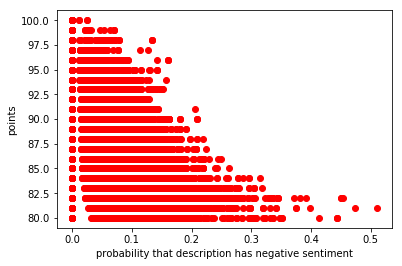

In [13]:
# plotting negative probabilities against points
plt.plot(sentiment_probs[:,2], points, 'ro')
plt.xlabel('probability that description has negative sentiment')
plt.ylabel('points')
plt.show()

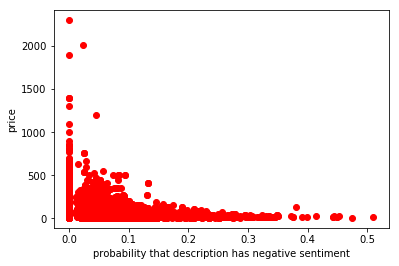

In [14]:
# plotting negative probabilities against price
plt.plot(sentiment_probs[:,2], prices, 'ro')
plt.xlabel('probability that description has negative sentiment')
plt.ylabel('price')
plt.show()

# Neural Network

In [28]:
import numpy as np
import gensim
import nltk
import string
# from textblob import Word

C:\Users\Liane_2\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
## must download stopwords for word embeddings
nltk.download_shell()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> corpora/stopwords
Command 'corpora/stopwords' unrecognized

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> corpora
Command 'corpora' unrecognized

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> l

Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [*] averaged_perceptron_tagger Averaged Perceptr

In [47]:
MAX_SEQUENCE_LENGTH = 20
embedding_depth = 300

### Word Embedding

In [29]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(string.punctuation)
stopwords.append('')
stopwords.remove('not')
stopwords.remove('no')

In [30]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()

In [31]:
embedding_dict = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [10]:
def sentence_to_tokens(s):
    return [token.lower().strip(string.punctuation) for token in tokenizer.tokenize(s)]

def word_to_vec(word):
    try:
        return embedding_dict[word]
    except:
        return np.zeros(300, dtype=float)
    


In [ ]:
# Function to generate a list of word vectors padded to be fixed length
def sentenceToArray(s, max_seq_length,word_vecs):
    z = np.zeros([300,])
    ary = []
    sentence_tokens = sentence2tokens(s)
    for token in sentence_tokens:
        wv = word2vecVocab(token,word_vecs)
        ary.append(wv)
    padding = max_seq_length - len(ary)
    if padding >= 0:
        for i in range(0,padding):
            ary.append(z)
    else:
        ary = ary[:max_seq_length]
    return np.array(ary)

#Function to map sentence to a muliti-hot vocab vector
def sentenceToVocabVec(s,word2index):
    vec = np.zeros([len(word2index),])
    sentence_tokens = sentence2tokens(s)
    for token in sentence_tokens:
        index = word2index[token]
        vec[index] = 1.0
    return vec

# create dictiarny of vocab words and word vectors
def vocabToVecs(vocab):
    word_vecs = {}
    for word in vocab:
        wv = word2vec(word)
        word_vecs[word] = wv
    return word_vecs

# build vocab
def generate_vocab(responses):
    tokens = []
    for r in responses:
        tk = sentence2tokens(r)
        tokens = tokens + tk
    token_list = list(set(tokens))
    return token_list

# create a word2index mapping
def wordToIndex(vocab_list):
    word2index = {x: i-1 for i, x in enumerate(vocab_list,1)}
    return word2index

# generate training data x = sentence arrays, y = vocab vectors
def generateTrainingData(responses,word2index,max_seq_len,word_vecs):
    x = []
    y = []
    for s in responses:
        x_ = sentenceToArray(s, max_seq_len,word_vecs)
        y_ = sentenceToVocabVec(s,word2index)
        x.append(x_)
        y.append(y_)
    return np.array(x), np.array(y)

#import raw responses from file
responses = load_raw_responses_from_file("training_data/pdf_data.tsv")
#responses = load_raw_responses_from_file("mercer_data/all_comments.tsv")

#generate vocab list from raw responses
vocab_list = generate_vocab(responses)

#load word2vec model
brain = loadWord2Vec()

#Create vocab only word vec model
word_vecs = vocabToVecs(vocab_list)

#delete brain to free up memeory
del brain

#generate word2index mapping
word2index = wordToIndex(vocab_list)

#generate training set
X, Y = generateTrainingData(responses,word2index,max_seq_len,word_vecs)

## ^^^^ takes ~1m to run per 100 responses
print (X.shape)
print (Y.shape)

In [48]:
def normalize(word):
    """
    Returns a lower cased version of a word and removes
    punctuation.
    """
    return word.lower().strip(string.punctuation)

def to_vector(word):
    """
    Convert a word to vector if we have a vector representation.
    """
    if word in embedding_dict:
        return embedding_dict[word]
    else:
        return np.zeros(300, dtype=float)
    
def tokenize(sentence):
    '''
    Converts string sentence into list of words. Strips punctuation,
    removes long words, makes lower case.
    '''
    tokens = []
    for token in tokenizer.tokenize(sentence):
        word = normalize(token)
        if word not in stopwords and len(word)<MAX_SEQUENCE_LENGTH:
            tokens.append(word)
    return tokens

def sentence_to_vec(sentence):
    '''
    Converts sentence into a float matrix = list of word vectors.
    '''
    import numpy as np
    z = np.zeros([300,])
    sentence_matrix = [to_vector(token) for token in tokenize(sentence)]
    padding = MAX_SEQUENCE_LENGTH - len(sentence_matrix)
    if padding >= 0:
        for i in range(0,padding):
            sentence_matrix.append(z)
    else:
        sentence_matrix = sentence_matrix[:MAX_SEQUENCE_LENGTH]
    return np.array(sentence_matrix)

def sentences_to_vecs(sentences):
    '''
    Converts list of sentences into list of sentence embeddings, 
    each embedding is MAX_SEQUENCE_LENGTH x 300.
    '''
    training_data = [sentence_to_vec(sentence) for sentence in sentences]
    return np.array(training_data)

In [49]:
embedded_sentences = sentences_to_vecs(descriptions)

In [50]:
print(type(embedded_sentences))

<class 'numpy.ndarray'>


In [52]:
print(embedded_sentences.shape)

(111009, 20, 300)


In [65]:
np.save('embedded.npy', embedded_sentences) 

In [ ]:
embedded_sentences = np.load('embedded.npy')

### Train the Network

In [ ]:
def dynamic_weighting_model(embedding_depth, max_seq_len, num_algs):
    '''
    Returns a model for sentiment analysis algorithm weight learning.
    Model inputs: array of sentence vectors (dimensions: sentences x 22 x 300), 
                  array of sentiment guesses for each algorithm (dimensions: sentences x algorithms x 3)
          outputs: array of sentiment answers (dimensions: sentences x 3)
    '''
    # add input layers
    main_input = Input(shape=(max_seq_len,embedding_depth), dtype='float32', name='main_input')
    algs_input = Input(shape=(num_algs,3), dtype='float32', name='algs_input')
    
    lstm = LSTM(300)
    lstm_main = lstm(main_input)
    
    dense_nn = Dense(num_algs, activation='softmax')
    dense_nn_main = dense_nn(lstm_main)
    
    # attention weighting
    dot = Dot(1)
    dot_main = dot([dense_nn_main,algs_input])
        
    # main model
    main_model = Model(inputs=[main_input,algs_input], outputs=[dot_main])
    op = RMSprop(lr=0.00007)
    main_model.compile(optimizer=op, loss='binary_crossentropy')
    
    return main_model

In [66]:
from keras.models import Sequential, Model
from keras.layers import Activation, Dot, Embedding, Conv1D, MaxPooling1D, Merge, Highway, LSTM, Dense, Dropout, Reshape, ActivityRegularization, Input
from keras.optimizers import SGD, RMSprop
from keras import regularizers
from keras.constraints import non_neg
from keras.initializers import TruncatedNormal

def descriptions_to_price(embedding_depth, max_seq_len):
    '''
    Returns a model for sentiment analysis algorithm weight learning.
    Model inputs: array of sentence vectors (dimensions: sentences x 22 x 300), 
                  array of sentiment guesses for each algorithm (dimensions: sentences x algorithms x 3)
          outputs: array of sentiment answers (dimensions: sentences x 3)
    '''
    # add input layers
    main_input = Input(shape=(max_seq_len,embedding_depth), dtype='float32', name='main_input')
#     price_input = Input(shape=(1), dtype='float32', name='price_input')
    
    lstm = LSTM(300)
    lstm_main = lstm(main_input)
    
    dense_nn = Dense(1, activation='softmax')
    dense_nn_main = dense_nn(lstm_main)
    
    # attention weighting
#     dot = Dot(1)
#     dot_main = dot([dense_nn_main,algs_input])
        
    # main model
    main_model = Model(inputs=[main_input], outputs=[dense_nn_main])
    op = RMSprop(lr=0.00007)
    main_model.compile(optimizer=op, loss='binary_crossentropy')
    
    return main_model

ModuleNotFoundError: No module named 'keras'

In [68]:
#build/compile model
model = descriptions_to_price(embedding_depth, MAX_SEQUENCE_LENGTH)

#view model summary
print (model.summary())

NameError: name 'descriptions_to_price' is not defined

In [ ]:
history = model.fit([embedded_sentences], prices, batch_size=128, epochs=5, verbose=2, validation_split=0.15)

### Predicting Price

In [ ]:
# use the model to make predictions on unseen data
model.predict(["this wine has beautiful flavors"])